<a href="https://colab.research.google.com/github/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_monte_carlo_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import random, math, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 

from IPython.display import display
from google.colab import files

# Set for animation display
rc('animation', html='jshtml')

!pip install git+https://github.com/rossant/ipycache.git
%load_ext ipycache
# %%cache [name of the cache] --force | --read 

# Class for Maze
Used in Dynamic Programming

In [0]:
class Maze:
    LEFT = "←"
    RIGHT = "→"
    UP = "↑"
    DOWN = "↓"
    START = "S"
    GOAL = "G"
    LEFT_DASH = "⇠"
    RIGHT_DASH = "⇢"
    UP_DASH = "⇡"
    DOWN_DASH = "⇣"

    S_START = (3, 0)
    S_GOAL = (5, 8)
    V_START = 1
    V_GOAL = 2
    V_WALL = 3

    FONTSIZE = 18

    REWARD = -1
    REWARD_GOAL = 50
    REWARD_NEXTGOAL = 25

    EPSILON = 0.1


    def __init__(self, width=9, height=6):
        self.image = plt.imread(
            "https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning" + 
            "/master/maze_optimal_path/icon/luzhuzhu.png")
        self.shape = (height, width)

        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def initSAP(self):
        # Initialize states
        gridStates = list(np.ndindex(self.shape))
        self.states = list(np.ndindex(self.shape))
        [self.states.remove(wall) for wall in self.wall_indexlist]

        # Initialize actions
        self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        self.actionSymbols = dict(zip(self.actions, [self.LEFT, self.RIGHT, self.UP, self.DOWN]))
        self.actionSymbolsRev = dict(zip([self.LEFT, self.RIGHT, self.UP, self.DOWN], self.actions))
        self.actionSymbols_dash = dict(zip(self.actions, [self.LEFT_DASH, self.RIGHT_DASH, self.UP_DASH, self.DOWN_DASH]))

        # Initialize policy and value function
        self.policy = {}
        self.value = {}
        for s in gridStates:
            self.value[s] = 0
        for s in self.states:
            canActionList = self.supposeAction(s)
            numAction = len(canActionList)
            _isGoal = self.isGoal(s)
            for alist in canActionList:
                a = alist[0]
                # With uniform random action
                self.policy[(s,a)] = 1/numAction if not _isGoal else 0

    def supposeAction(self, s):
        canActionList = []
        _isGoal = self.isGoal(s)
        for a in self.actions:
            reward = self.REWARD
            s_new = tuple(np.asarray(s) + np.asarray(a)[::-1])
            canAction = s_new in self.states
            canGoal = s_new == self.S_GOAL
            if canAction and canGoal: reward = self.REWARD_NEXTGOAL
            if _isGoal: reward = self.REWARD_GOAL; s_new = self.S_GOAL
            if canAction: canActionList.append([a, reward, s_new])
        return canActionList

    def chooseAction(self, s):
        canActionList = self.supposeAction(s)
        # policy_max = max([value for key, value in self.policy.items() if key[0] == s])
        policyActionList = [alist for alist in canActionList]
        policyWeightList = [self.policy[(s, alist[0])] for alist in canActionList]
        policyAction = random.choices(policyActionList, weights=policyWeightList, k=1)[0]
        return policyAction

    def mkPlt(self):
        # Make a color map of fixed colors
        self.cmap = colors.ListedColormap(["white", "yellow", "grey"])
        bounds=[0.5, 1.5, 2.5, 9.5]
        self.norm = colors.BoundaryNorm(bounds, self.cmap.N)

        # Make new figure and subplot axes
        self.fig, self.axes = plt.subplots(1,2, figsize=(15, 5))
        plt.close()

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[2:5,2] = self.V_WALL
        self.maze[1,5] = self.V_WALL
        self.maze[3:6,7] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

    def isWall(self, s):
        if self.maze[s] == self.V_WALL:
            return True
        else:
            return False

    def isGoal(self, s):
        if self.maze[s] == self.V_GOAL:
            return True
        else:
            return False 

    def setImage(self, ax, loc):
        im = OffsetImage(self.image, zoom=0.072, resample=True)
        ab = AnnotationBbox(im, loc, xycoords='data', frameon=False, box_alignment=(0.5, 0.5)) 
        ab.set_zorder(1)
        ax.add_artist(ab)

    # Set maze layout for plot
    def setMaze(self, ax):
        argMark = dict(fontsize=self.FONTSIZE, ha="center", va="center")

        # Basic axes setting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("on")
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["right"].set_linewidth(0.5)
        ax.spines["top"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_color("k")
        ax.spines["right"].set_color("k")
        ax.spines["top"].set_color("k")
        ax.spines["bottom"].set_color("k")

        # Plot maze layout
        ax.pcolor(self.maze,snap="true", edgecolors="k", linewidths=0.5, cmap=self.cmap, norm=self.norm)

        # Add mark for start and goal and current location
        loc = (self.S_START[1] + 0.5, self.S_START[0] + 0.5)
        self.setImage(ax, loc)
        ax.text(self.S_START[1] + 0.5, self.S_START[0] + 0.5, self.START, **argMark)
        ax.text(self.S_GOAL[1] + 0.5, self.S_GOAL[0] + 0.5, self.GOAL, **argMark)

        # Prevent auto plot.show() in google colab
        plt.close()

    # Set the possible action according to policy
    def setAction(self, ax):
        actionColor = "deepskyblue"
        argActionLeft = dict(fontsize=self.FONTSIZE, ha="right", va="center", color=actionColor)
        argActionRight = dict(fontsize=self.FONTSIZE, ha="left", va="center", color=actionColor)
        argActionUp = dict(fontsize=self.FONTSIZE, ha="center", va="bottom", color=actionColor)
        argActionDown = dict(fontsize=self.FONTSIZE, ha="center", va="top", color=actionColor)
        argAction = dict(zip(self.actions, [argActionLeft, argActionRight, argActionUp, argActionDown]))

        # Add action directions for all cell
        for s in self.states:
            if self.isGoal(s): continue
            j = s[0] + 0.5
            i = s[1] + 0.5
            for a in self.actions:
                try:
                    policy = self.policy[(s, a)]
                except KeyError:
                    continue
                if policy <= 0: continue
                actionSymbol = self.actionSymbols[a] if policy > self.EPSILON else self.actionSymbols_dash[a]
                arg = argAction[a]
                ax.text(i, j, actionSymbol, **arg)
        plt.close()

    # Set the value of value function for heatmap
    def setValue(self, ax):
        value = np.zeros(self.shape)
        for s in self.value.keys():
            value[s] = self.value[s]

        # Plot heatmap
        pc = ax.pcolor(value, snap="true", edgecolors="w", linewidths=0.5)

        # Add value text for heatmap
        pc.update_scalarmappable()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            red, green, blue = color[:3]*255
            brightness = (red*0.299 + green*0.587 + blue*0.114) > 180 #186
            color = "k" if brightness else  "w"
            ax.text(x, y, str(round(value, 2)), ha="center", va="center", color=color)
        plt.close()

    # Trigger to draw maze layout, policy and heatmap
    def draw(self):
        [ax.cla() for ax in self.axes]
        self.setMaze(self.axes[0])
        self.setAction(self.axes[0])
        self.setValue(self.axes[1]) 
        display(self.fig)

    # Get the steps that from start to goal of optimal policy
    def getNumActions(self):
        numActions = 0
        curState=self.S_START
        while True:
            numActions += 1
            nextState = self.chooseAction(curState)[-1]
            curState = nextState
            if curState == self.S_GOAL: return numActions

    # Animate the jerry"s actions in maze
    def animate(self):
        self.fig_ani, self.ax_ani = plt.subplots(1,figsize=(7.5, 5)) 
        self.setMaze(self.ax_ani)
        self.setAction(self.ax_ani)
        if self.isLearn:
            frames = self.getNumActions() + 1
        else:
            frames = 20
        framesSet = frames*5

        self.luzhuzhu = self.ax_ani.artists[0]

        # Reset luzhuzhu"s location
        def resetPos():
            curState = self.S_START
            curPos = tuple(np.add(curState, (0.5, 0.5))[::-1])
            self.luzhuzhu.xyann = curPos

        # Animate
        def setAnimate(i):
            curPos = self.luzhuzhu.xyann
            curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
            if i+1 % frames == 1: 
                resetPos()
                return self.ax_ani,
            else:
                curPos = self.luzhuzhu.xyann
                curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
                curState_int = tuple(int(x) for x in curState)
                nextState = self.chooseAction(curState_int)[-1]
                nextPos = tuple(np.add(nextState, (0.5, 0.5))[::-1])
                self.luzhuzhu.xyann = nextPos
                if curState == self.S_GOAL and nextState == self.S_GOAL:
                    resetPos()
                    return self.ax_ani,
                return self.ax_ani,

        # Call to aniamte
        self.anim = animation.FuncAnimation(self.fig_ani, setAnimate,
                                            frames=framesSet, interval=250, blit=False)
        
        # Option to write animation to mp4 and turn off rc('animation', html='jshtml')
        # writer = animation.writers["ffmpeg"](fps=3)
        # if self.isLearn:
        #     filename = "maze-optimal-path_dynamic-programming_demo_afterLearning.mp4"
        # else:
        #     filename = "maze-optimal-path_dynamic-programming_demo_beforeLearning.mp4"
        # self.anim.save(filename,writer=writer,dpi=300)
        # files.download(filename)

# Class for Maze mini
Used for verification and validation (sampling needs a lot computing resouce, so I need to deploy a simpler case)

In [0]:
class Maze_mini(Maze):
    LEFT = "←"
    RIGHT = "→"
    UP = "↑"
    DOWN = "↓"
    START = "S"
    GOAL = "G"
    LEFT_DASH = "⇠"
    RIGHT_DASH = "⇢"
    UP_DASH = "⇡"
    DOWN_DASH = "⇣"

    S_START = (0, 0)
    S_GOAL = (2, 4)
    V_START = 1
    V_GOAL = 2
    V_WALL = 3

    FONTSIZE = 18

    REWARD = -1
    REWARD_GOAL = 50
    REWARD_NEXTGOAL = 25


    def __init__(self, width=5, height=3):
        self.image = plt.imread(
            "https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning" + 
            "/master/maze_optimal_path/icon/luzhuzhu.png")
        self.shape = (height, width)
        self.countDraw = 0

        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def setImage(self, ax, loc):
        im = OffsetImage(self.image, zoom=0.12, resample=True)
        ab = AnnotationBbox(im, loc, xycoords='data', frameon=False, box_alignment=(0.5, 0.5)) 
        ab.set_zorder(1)
        ax.add_artist(ab)

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[0,1] = self.V_WALL
        self.maze[1,3] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

# Materials
## On-policy
| Exploring Starts | On-policy ε-soft policies |
|---|---|
|<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_ES.png" width="600"/> | <img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_onpolicy-firstvisit-epsilonsoft.png" width="600"/>|

## Off-policy
| Policy Evaluation | MC Control |
|---|---|
|<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_offpolicy-policyEvaluation.png" width="600"/> | <img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_offpolicy-control.png" width="600"/>|

#Hints
- When you reverse the order of episode for loop, G<-gamma*G + R will work for below formula.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_G_sum.png" width="300"/>
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_G_iteration.png" width="600"/>

-  When you update the policy after one episode or some episodes, you will encounter the dilemma which leads to infinite loop.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_MC_ES_dilemma.png" width="600"/>

# Class for Monte Carlo Methods



In [0]:
class RL_mc:
    def __init__(self, maze):
        self.maze = maze
        # Make math.isclose gives "right" comparison result when according to heatmap
        self.mathclose = 1e-5
        self.stepTolerant = 500
        self.stateStart = self.maze.S_START
        # pairs = [(s, alist[0]) for s in self.maze.states for alist in self.maze.supposeAction(s)]

    def generateStart(self, es=False):
        s_start = random.choice(self.maze.states) if es else self.stateStart
        a_start, r_start, s_new = random.choice(self.maze.supposeAction(s_start))
        start = [s_start, a_start, r_start, s_new]
        """Trace set: print the starts of exploring start"""
        # print("\nStart: {}, action: {}".format(s_start, self.maze.actionSymbols[a_start]))
        return start

    def generateEpisode(self, es=False):
        self.dilemma = False
        self.episode = []
        self.path = []
        start = self.generateStart(es)
        self.episode.extend(start)
        self.path.extend(start[::len(start)-1])
        numStep = 0
        while True:
            numStep += 1
            s_tail = self.episode[-1]
            if numStep > self.stepTolerant:
                self.dilemma = True
                break
            if s_tail == self.maze.S_GOAL: 
                step = self.maze.chooseAction(s_tail)
                self.episode.extend(step)
                self.episode.pop(); 
                it = iter(self.episode)
                self.episode = list(zip(it, it, it))
                break
            step = self.maze.chooseAction(s_tail)
            self.episode.extend(step)
            self.path.append(step[-1])

    def onpolicy_updateQ(self, firstVisit=True, reward_decline=1.0):
        """Trace set: Draw the episode path, use it when debugging or tracing"""
        # self.drawEpisode()
        self.episode.reverse()
        G = 0
        for idx, (s, a, r) in enumerate(self.episode):
            sa = (s, a)
            [x.update({sa: 0})
                for x in [self.counterSA, self.q] 
                if not sa in x.keys()]

            allVisit_idx = list(i for i, step in enumerate(self.episode) if step[0:2] == sa)
            firstVisit_idx = allVisit_idx[-1]
            if firstVisit: 
                if firstVisit_idx == idx and len(allVisit_idx) > 1: continue
            G = reward_decline*G + r
            self.counterSA[sa] += 1
            nsa = self.counterSA[sa]
            self.q[sa] = (nsa-1)*self.q[sa]/nsa + G/nsa
            """
            Update value function of state by average, 
            """
            ns = sum([value for key, value in self.counterSA.items() if key[0] == s])
            self.maze.value[s] = (ns-1)*self.maze.value[s]/ns + G/ns

    def onpolicy_updatePolicy(self, epsilon=0):
        stateList = list(dict.fromkeys([s for (s, a, r) in self.episode]))
        for s in stateList:
        # for (s, a, r) in self.episode:
            """Trace set: Draw the episode step by step, use it when debugging or tracing"""
            # self.drawEpisode(cur=s)

            # Set all chooseAction
            policy_old = {key: value for key, value in self.maze.policy.items() if key[0] == s}
            # self.maze.policy.update(policy_zero)
            salist = [key for key, value in self.maze.policy.items() if key[0] == s]

            """Trace set: Draw the episode step by step, use it when debugging or tracing"""
            # print("reset state {}'s policy".format(s)); self.maze.draw()

            q = {key: value for key, value in self.q.items() if key[0] == s}
            qmax_value = max(q.values(), default=0)
            qmax = {key: value 
                    for key, value in q.items() 
                    if math.isclose(value, qmax_value, abs_tol=self.mathclose)}
            policy_new = {key: (1 - epsilon + epsilon/len(salist))/len(qmax) 
                           if key in qmax.keys() else epsilon/len(salist) 
                           for key in salist}
            # if len(qmax) > 1 and qmax_value != 50.0:
            #     print("\n s = {}".format(s))
            #     print("-----------------------------------------------------------------------------------")
            #     print("policy_old: \n{}".format(policy_old))
            #     print("q: \n{}".format(q))
            #     print("qmax_value: {}".format(qmax_value))
            #     print("qmax: \n{}".format(qmax))
            #     print("policy_new: \n{}".format(policy_new))
            #     print()
            self.maze.policy.update(policy_new)

            """Trace set: Draw the episode step by step, use it when debugging or tracing"""
            # print("update state's {}'s policy".format(s)); self.maze.draw()

    def exploringStart(self, numEpisode=1, reward_decline=1.0):
        self.counterSA = {}
        self.q = {}

        for i in range(numEpisode):
            sys.stdout.write('\rLoop: '+str(i+1))
            self.generateEpisode(es=True)
            # Skip the closed episode that can't reach the goal
            if self.dilemma: continue
            self.onpolicy_updateQ(reward_decline)
            self.onpolicy_updatePolicy()

    def epsilonSoft(self, numEpisode=1, reward_decline=1.0, epsilon = 0.1, stateStart= (0,0)):
        self.counterSA = {}
        self.q = {}
        self.maze.EPSILON = epsilon
        if stateStart != (0,0): self.stateStart = stateStart

        for i in range(numEpisode):
            # plotu = False
            sys.stdout.write('\rLoop: '+str(i+1))
            self.generateEpisode()
            # Skip the closed episode that can't reach the goal
            if self.dilemma: continue
            self.onpolicy_updateQ(reward_decline)
            self.onpolicy_updatePolicy(epsilon)

    """
    TODO
    """
    def offpolicy(self, numEpisode=1, reward_decline=1.0, epsilon = 0.1, stateStart= (0,0)):
        self.counterSA = {}
        self.q = {}
        self.maze.EPSILON = epsilon
        if stateStart != (0,0): self.stateStart = stateStart

        for i in range(numEpisode):
            # plotu = False
            sys.stdout.write('\rLoop: '+str(i+1))
            self.generateEpisode()
            # Skip the closed episode that can't reach the goal
            if self.dilemma: continue
            self.onpolicy_updateQ(reward_decline)
            self.onpolicy_updatePolicy(epsilon)

    def drawEpisode(self, cur=(-1,-1)):
        showstep = cur != (-1,-1)
        argMark = dict(fontsize=self.maze.FONTSIZE, ha="center", va="center", color="r")
        verts = [(p[1] + 0.5, p[0] + 0.5) for p in self.path]
        xs, ys = zip(*verts)

        self.fig_epi, self.axes = plt.subplots(1, 2, figsize=(15, 5)) 
        self.ax_epi = self.axes[0]
        self.ax_value = self.axes[1]
        self.maze.setMaze(self.ax_epi)
        self.maze.setAction(self.ax_epi)
        self.maze.setValue(self.ax_value)
        self.ax_epi.plot(xs, ys, '--', color="purple") #"deepskyblue"

        if not showstep:
            self.ax_epi.text(verts[0][0], verts[0][1], "●", **argMark)
        else:
            self.ax_epi.text(cur[1] + 0.5, cur[0] + 0.5, "◆", **argMark)

        display(self.fig_epi)

# Trial of solving Maze
When test, I found the computing sonsumes time when do V&V, so a mini model of Maze is needed for quick check. Actually it doesn't take that much.

## Exploring Start
You can make not bad approximate results from ES under finite episodes compared to Dynamic Progamming showed below [DP github url](https://github.com/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb):
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Maze_DP.png" width="600"/>  
The bigger states space, the more episodes are needed to generate quite good approximation.

[Saved variables '' to file '/content/Maze_MC_ES'.]
Initialize the maze
Learning
Loop: 20000CPU times: user 1min 10s, sys: 949 ms, total: 1min 11s
Wall time: 1min 10s


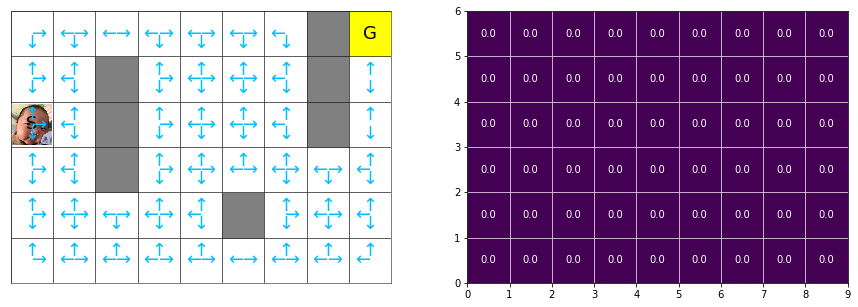

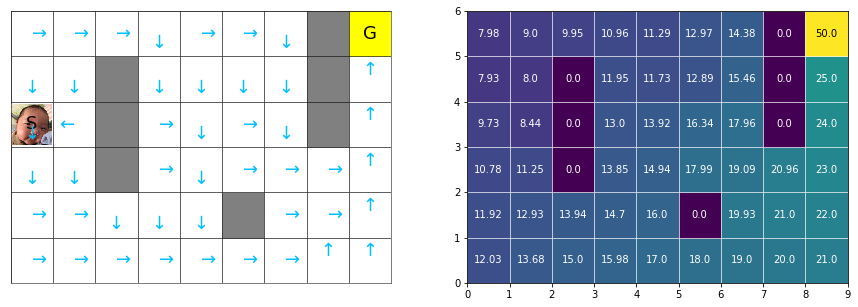

In [0]:
%%cache Maze_MC_ES
%%time

print("Initialize the maze")
maze = Maze()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.exploringStart(numEpisode=20000)
maze.draw()

# Trial of solving Maze mini
Test the algorithmn with Maze_mini a simple model for maze.  

## On-policy Exploring Start
You can make quite good approximate results from ES compared to Dynamic Progamming showed below [DP github url](https://github.com/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb):
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_DP.png" width="600"/>  
You need more computing resource, and you may get quite different results under the same number of episodes. Because exploring start give a random $(s_0, a_0)$ that does not obey current policy $\pi$.

However, in reality use case you cannot start at a random state to explore the episode.

Run a one million episodes MC ES, resutls show us that EC can't converge to the optimal comparing with DP.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_MC_ES_1million.png" width="600"/> 


**MIssion**: when have time, show q(s,a) value in maze plot.


[Saved variables '' to file '/content/MazeMini_MC_ES'.]
Initialize the maze
Learning
Loop: 20000CPU times: user 12.6 s, sys: 723 ms, total: 13.3 s
Wall time: 12.7 s


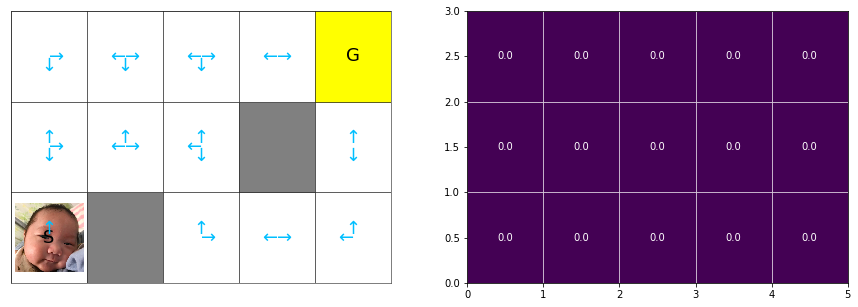

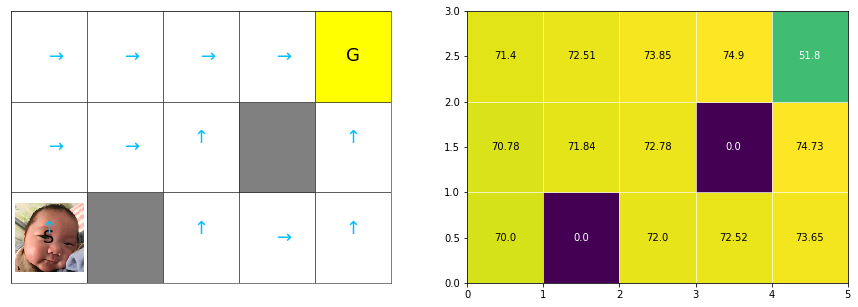

In [92]:
%%cache MazeMini_MC_ES
%%time

print("Initialize the maze")
maze = Maze_mini()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.exploringStart(numEpisode=20000)
maze.draw()

## On-policy $\epsilon$-soft policies
In on-policy control methods the policy is generally soft, meaning that $\pi(a|s)$
for all $s \in S$ and all $a \in A(s)$, but gradually shifted closer and closer to a deterministic
optimal policy. 

According to the results, the $\epsilon$-soft policies won't perform well like ES method.

[Saved variables '' to file '/content/MazeMini_MC_EpsilonSoft'.]
Learning from location: (0, 0)
Loop: 20000CPU times: user 18.6 s, sys: 696 ms, total: 19.3 s
Wall time: 18.8 s


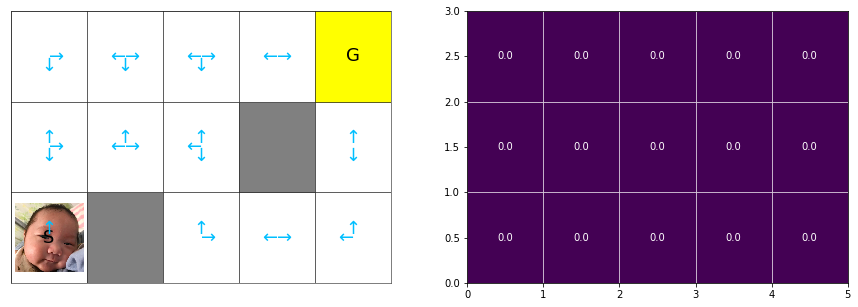

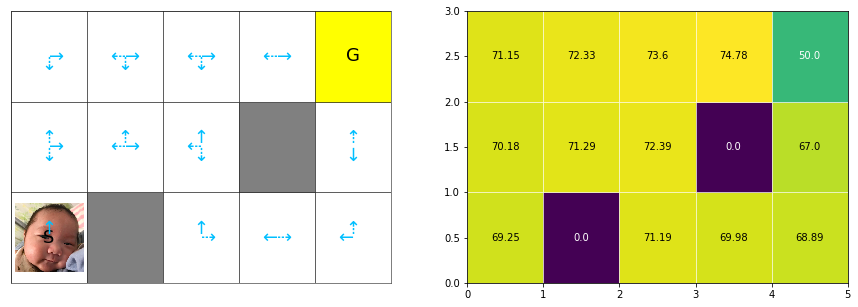

In [104]:
%%cache MazeMini_MC_EpsilonSoft
%%time

# print("Initialize the maze")
maze = Maze_mini()
maze.draw()

loop = maze.states if 0 else [maze.S_START]
for s in loop:
    stateStart = s
    print("Learning from location: {}".format(stateStart))
    rlmc = RL_mc(maze)
    rlmc.epsilonSoft(numEpisode=20000, epsilon=0.2, stateStart=stateStart)
    maze.draw()

## Off-policy
I like the style of introduction for off-policy:
> All learning control methods face a dilemma: They seek to learn action values conditional on subsequent optimal behavior, but they need to behave non-optimally in order to explore all actions (to find the optimal actions). How can they learn about the optimal policy while behaving according to an exploratory policy? The on-policy approach in the preceding section is actually a compromise—it learns action values not for the optimal policy, but for a near-optimal policy that still explores. A more straightforward approach is to use two policies, one that is learned about and that becomes the optimal policy, and one that is more exploratory and is used to generate behavior. The policy being learned about is called the target policy, and the policy used to generate behavior is called the behavior policy. In this case we say that learning is from data “off” the target policy, and the overall process is termed off-policy learning.

In [0]:
%%cache MazeMini_MC_offpolicy
%%time

# print("Initialize the maze")
maze = Maze_mini()
maze.draw()

loop = maze.states if 0 else [maze.S_START]
for s in loop:
    stateStart = s
    print("Learning from location: {}".format(stateStart))
    rlmc = RL_mc(maze)
    rlmc.offpolicy(numEpisode=20000, epsilon=0.2, stateStart=stateStart)
    maze.draw()

# Summary

Difference are between the Monte Carlo methods and the DP methods in two major ways. 

1. First, they operate on sample experience, and thus can be used for direct learning without a model. 
1. Second, they do not bootstrap. That is, they do not update their value estimates on the basis of other value estimates. 

These two differences are not tightly linked, and can be separated. 

In the next chapter we consider methods that learn from experience, like Monte Carlo methods, but also bootstrap, like DP methods.

## What is bootstrap?
![](https://img.huffingtonpost.com/asset/5b6b3f1f2000002d00349e9d.jpeg?cache=92vfjlaeaf&ops=scalefit_720_noupscale "source: ISABELLA CARAPELLA/HUFFPOST")  
source: ISABELLA CARAPELLA/HUFFPOST

If you want to release the most inner strap, you have to release other strap that related to it.